## Naive Bayes Classification

In [1]:
#Author-Vishal Burman

In [2]:
import matplotlib.pyplot as plt
from mxnet import nd, gluon
import math
%matplotlib inline

In [4]:
#We download the mnist dataset through mxnet's Gluon high-level API
#We normalize the image and remove the last dimension

In [3]:
def transform(data, label):
    return nd.floor(data/128).astype('float32').squeeze(axis=-1), label
mnist_train=gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test=gluon.data.vision.MNIST(train=False, transform=transform)

In [5]:
#We can access a particular example

In [6]:
image, label=mnist_train[2]

In [7]:
image.shape, label

((28, 28), 4)

In [8]:
image.shape, label.dtype

((28, 28), dtype('int32'))

In [9]:
#We can also access multiple examples at the same time

In [10]:
images, labels=mnist_train[10:38]

In [11]:
images.shape, label.dtype

((28, 28, 28), dtype('int32'))

In [12]:
#Creating a function to visualise these samples

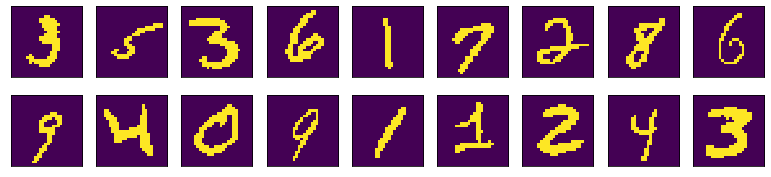

In [16]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    axes = plt.subplots(num_rows, num_cols, figsize=figsize)[1].flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

show_images(images, 2, 9);

In [17]:
##Using the naive bayes classifier on mnist dataset

In [ ]:
#Using the chain rule of probablities
#p(x|y)=p(x1|y).p(x2|x1, y)....p(xd|x1...xd-1, y)
#The above calculation is still like 2^d parameters
#If we make an assumption that each feature are independent
#The equation reduces to argmax{Product(p(xi|y)*p(y)) i=i->d}

In [ ]:
#First we calculate the p(y) which is the probablity of each number appearing in the dataset

In [18]:
X, Y=mnist_train[:]

n_y=nd.zeros((10))
for y in range(10):
    n_y[y]=(Y==y).sum()
P_y=n_y/n_y.sum()
P_y


[0.09871667 0.11236667 0.0993     0.10218333 0.09736667 0.09035
 0.09863333 0.10441667 0.09751666 0.09915   ]
<NDArray 10 @cpu(0)>

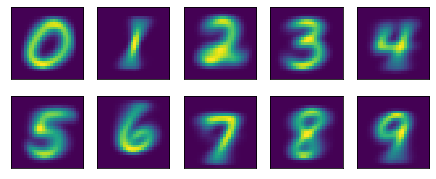

In [19]:
n_x=nd.zeros((10, 28, 28))
for y in range(10):
    n_x[y]=nd.array(X.asnumpy()[Y==y].sum(axis=0))
P_xy = (n_x+1) / (n_y+1).reshape((10,1,1))
show_images(P_xy, 2, 5);

In [20]:
def bayes_pred(x):
    x=x.expand_dims(axis=0)
    p_xy=P_xy*x+(1-P_xy)*(1-x)
    p_xy=p_xy.reshape((10, -1)).prod(axis=1)
    return p_xy*P_y
image, label=mnist_test[0]
bayes_pred(image)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<NDArray 10 @cpu(0)>

In [25]:
#Well the above went horribly wrong...its numerical underflow ie multiplying all the small numbers
#leads to something smaller until it is rounded down to zero

In [26]:
#To fix the above problem we use the following property:
#log ab=log a+ log b

In [24]:
a=0.1
print("underflow", a**784)
print("logarithm is normal", 784*math.log(a))

underflow 0.0
logarithm is normal -1805.2267129073316


In [31]:
log_P_xy=nd.log(P_xy)
log_P_xy_neg=nd.log(1-P_xy)
log_P_y=nd.log(P_y)
def bayes_pred_stable(x):
    x = x.expand_dims(axis=0)  # (28, 28) -> (1, 28, 28)
    p_xy = log_P_xy * x + log_P_xy_neg * (1-x)
    p_xy = p_xy.reshape((10,-1)).sum(axis=1) # p(x|y)
    return p_xy + log_P_y

py = bayes_pred_stable(image)
py


[-269.0042  -301.73447 -245.21458 -218.8941  -193.46907 -206.10315
 -292.54315 -114.62834 -220.35619 -163.18881]
<NDArray 10 @cpu(0)>

In [32]:
#Checking if the prediction is correct

In [33]:
py.argmax(axis=0).asscalar()==label

True

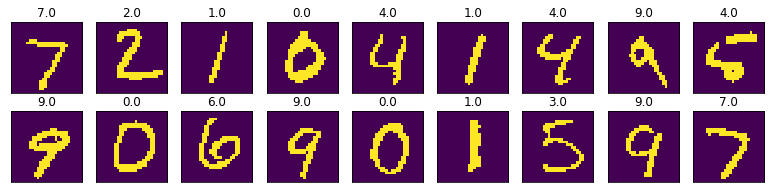

In [34]:
def predict(X):
    return [bayes_pred_stable(x).argmax(axis=0).asscalar() for x in X]

X, y = mnist_test[:18]
show_images(X, 2, 9, titles=predict(X));

In [35]:
#Computing the overall accuracy of the classifier

In [36]:
X, y = mnist_test[:]
py = predict(X)
'Validation accuracy', (nd.array(py).asnumpy() == y).sum() / len(y)

('Validation accuracy', 0.8426)

In [37]:
#The poor performance is due to incorrect statistical assumptions that we made in our model:
#We assumed each and every pixel is independently generated depending only on the label